## Face mask detection

### Importing libraries 

In [16]:
import os
import cv2
import pathlib
import re
import glob

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from numpy.random import default_rng
import seaborn as sn; sn.set(font_scale=1.4)


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import MobileNetV2

from sklearn.model_selection import train_test_split

### Global constants

In [6]:
data_dir = "../dataset"
batch_size = 32

data_dir = pathlib.Path(data_dir)
IMG_SIZE = 150

class_names = ['with_mask', 'without_mask']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

In [7]:
def prepare_dataset(path):
    """
    Read images from the path & preprocess it
    
    Args:
        path(String/pathlib) - path of the image files
    
    Returns:
        x - processed X data
        y - corresponding y labels of x
    """
    x = []
    y = []
    
    path = pathlib.Path(path)
    
    sub_folders = [x for x in data_dir.iterdir()] 
    
    for folder in sub_folders:
        images_path= folder.glob('**/*.jpg')
        
        for img_path in images_path :
            img=load_img(img_path, target_size=(IMG_SIZE,IMG_SIZE))
            img=img_to_array(img)
            img=img/255.0
            x.append(img)
            y.append(class_names_label[folder.name])
    
    return np.array(x),np.array(y)

In [8]:
x,y = prepare_dataset(data_dir)

In [9]:
def split_train_test(x,y,test_ratio = 0.2):
    """
    Split the given data into test and train set
    
    Args:
        x(numpy array): x data with first dimension as the samples
        y(numpy array): corresponding labels to x 
        test_ratio(0-1): ratio of data required for test set
        
    Returns:
        x_train(numpy_array) - training x data
        y_train(numpy_array) - training y data
        x_test(numpy_array) - test x data
        y_test(numpy_array) - test y data
        
    """
    
    X_train, X_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=test_ratio,
                                                    random_state=42)
    return X_train, X_test, y_train, y_test

In [10]:
x_train, x_test, y_train, y_test = split_train_test(x,y)

### Checking the shape of the content


In [11]:
print("Number of samples in training:" + str(x_train.shape[0]))
print("Number of samples in test:" + str(x_train.shape[1]))

print("Dimension of each sample: " + str(x_train.shape[1:]))

Number of samples in training:1100
Number of samples in test:150
Dimension of each sample: (150, 150, 3)


### Distribution of class in test and train

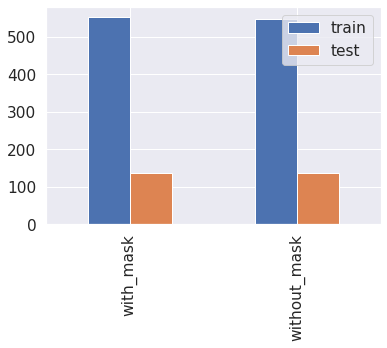

In [17]:
_, train_counts = np.unique(y_train, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

### Sample images from train & test

In [18]:
rng = default_rng()
numbers = rng.choice(x, size=10, replace=False)

In [19]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [20]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

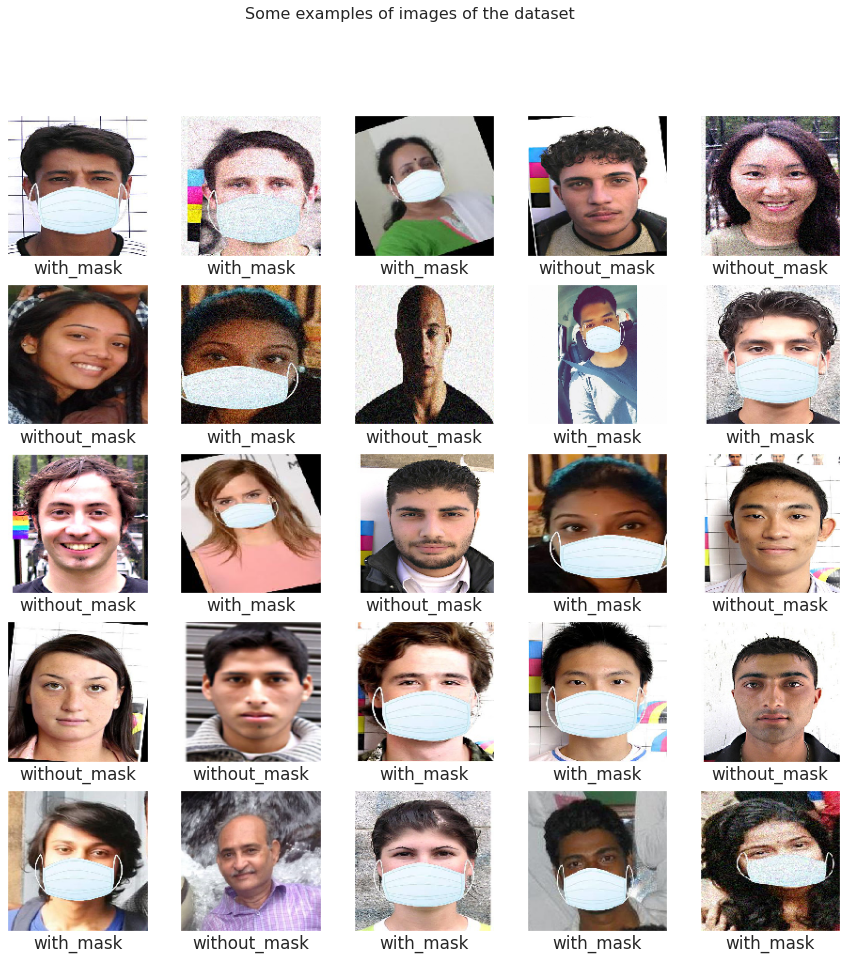

In [22]:
display_examples(class_names,x_train,y_train)

### Todo

* Display some random images
* Split the data to train and test set - done
* Display the class level split in both test and train

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               5308544   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [14]:
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [15]:
history=model.fit(x=x_train,y=y_train,epochs=100,validation_data=(x_test,y_test))

Epoch 1/100
35/35 [==============================] - 11s 305ms/step - loss: 0.6419 - acc: 0.6582 - val_loss: 0.4753 - val_acc: 0.8949
Epoch 2/100
35/35 [==============================] - 10s 292ms/step - loss: 0.4393 - acc: 0.8164 - val_loss: 0.3834 - val_acc: 0.8188
Epoch 3/100
35/35 [==============================] - 11s 307ms/step - loss: 0.2899 - acc: 0.8973 - val_loss: 0.2082 - val_acc: 0.9275
Epoch 4/100
35/35 [==============================] - 11s 319ms/step - loss: 0.2124 - acc: 0.9318 - val_loss: 0.2215 - val_acc: 0.8986
Epoch 5/100
35/35 [==============================] - 11s 320ms/step - loss: 0.1738 - acc: 0.9409 - val_loss: 0.1981 - val_acc: 0.9529
Epoch 6/100
35/35 [==============================] - 11s 318ms/step - loss: 0.1453 - acc: 0.9527 - val_loss: 0.1098 - val_acc: 0.9601
Epoch 7/100
35/35 [==============================] - 11s 317ms/step - loss: 0.1117 - acc: 0.9636 - val_loss: 0.0872 - val_acc: 0.9746
Epoch 8/100
35/35 [==============================] - 11s 319ms

35/35 [==============================] - 11s 312ms/step - loss: 2.0570e-04 - acc: 1.0000 - val_loss: 0.1007 - val_acc: 0.9819
Epoch 62/100
35/35 [==============================] - 11s 310ms/step - loss: 6.9785e-04 - acc: 1.0000 - val_loss: 0.0960 - val_acc: 0.9783
Epoch 63/100
35/35 [==============================] - 11s 313ms/step - loss: 1.4348e-04 - acc: 1.0000 - val_loss: 0.0996 - val_acc: 0.9783
Epoch 64/100
35/35 [==============================] - 11s 313ms/step - loss: 1.2492e-04 - acc: 1.0000 - val_loss: 0.1173 - val_acc: 0.9746
Epoch 65/100
35/35 [==============================] - 11s 311ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.1122 - val_acc: 0.9819
Epoch 66/100
35/35 [==============================] - 11s 312ms/step - loss: 8.1294e-05 - acc: 1.0000 - val_loss: 0.1053 - val_acc: 0.9783
Epoch 67/100
35/35 [==============================] - 11s 312ms/step - loss: 3.6359e-04 - acc: 1.0000 - val_loss: 0.1140 - val_acc: 0.9783
Epoch 68/100
35/35 [========================

### Error and Accuracy charts

In [23]:
def plot_train_test_loss(history):
    hist = history.history
    
    fields = ['loss', 'val_loss', 'acc', 'val_acc']
    
    axs = plt.figure(figsize=(14,12),constrained_layout=True).subplots(2,1)
    
    # accuracy graph
    for i,ax in zip(range(0,4,2),axs):
#         ax.plot(hist[fields[i]],label=fields[i],linewidth=20)
        
        sn.lineplot(y=hist[fields[i]],x=range(0,100),ax=ax,label=fields[i],marker='o')
        sn.lineplot(y=hist[fields[i+1]],x=range(0,100),ax=ax, label=fields[i+1],marker='o')
        

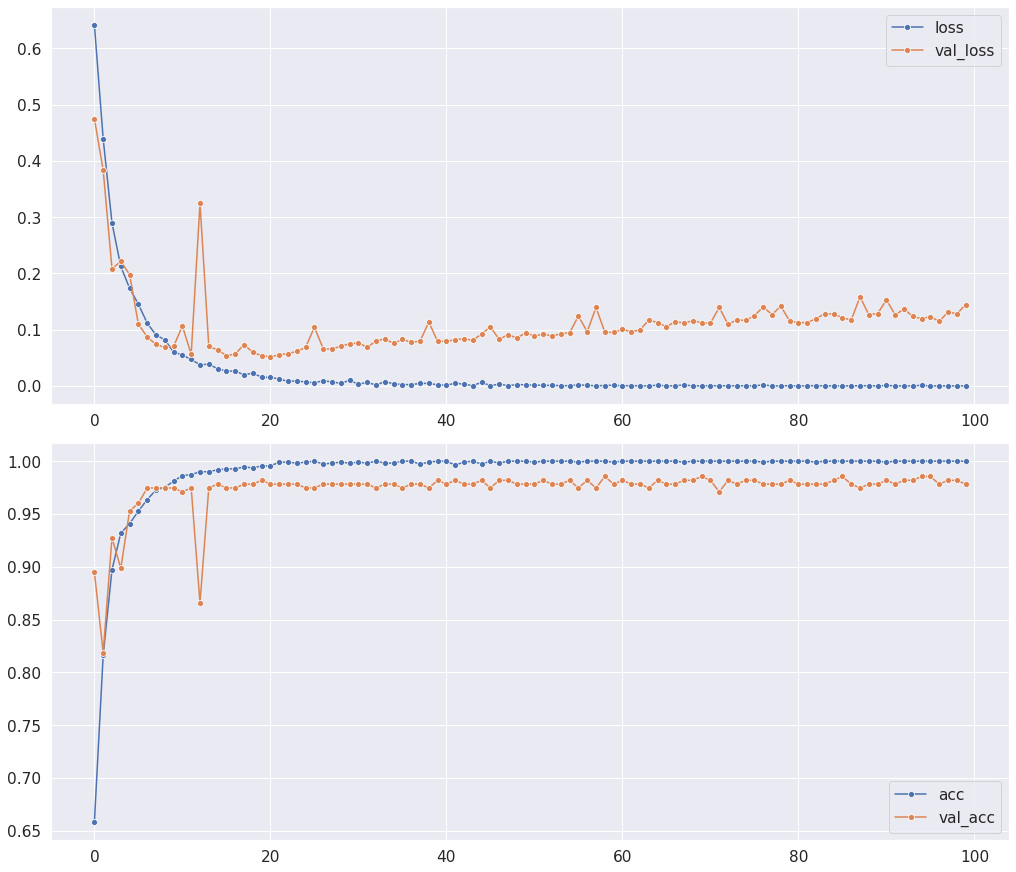

In [24]:
plot_train_test_loss(history)